# Get a hand on

This notebook aims at providing a simple demo on the library's tools.

In [1]:
# import sys
# sys.path.insert('../..')

In [4]:
import matplotlib.pyplot as plt
import os
import torch
from torchvision import transforms
from tqdm import tqdm

from IPython.display import clear_output
from sklearn.metrics import accuracy_score

from oodeel.methods import Mahalanobis
from oodeel.eval.metrics import bench_metrics
from oodeel.eval.plots import plot_ood_scores, plot_roc_curve, plot_2D_features
from oodeel.datasets import OODDataset
from oodeel.utils.torch_training_tools import train_torch_model

from utils.utils_models import load_model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
path_to_networks = os.path.abspath('./data/models')
path_to_datasets = os.path.abspath('./data/datasets')
os.makedirs(path_to_networks, exist_ok=True)
os.makedirs(path_to_datasets, exist_ok=True)

## Example 1 - ResNet on CIFAR10 & SVHN

<div style='text-align: justify'>

In this example, we monitor a `ResNet34` trained on an in-distribution (ID) dataset 'CIFAR-10'. We evaluate the monitor on the 'test' split of the ID dataset as well as the out-of-distribution (OOD) dataset 'SVHN'.
</div>

### Load the datasets

In [3]:
batch_size = 128

# Load datasets (train, test I, test O)
data_train = OODDataset(
    dataset_id='CIFAR10', backend="torch",
    load_kwargs={"root": path_to_datasets, "train": True, "download": True}
)
data_test_I = OODDataset(
    dataset_id='CIFAR10', backend="torch",
    load_kwargs={"root": path_to_datasets, "train": False, "download": True}
)
data_test_O = OODDataset(
    dataset_id='SVHN', backend="torch",
    load_kwargs={"root": path_to_datasets, "split": "test", "download": True}
)

# Prepare data (preprocess, shuffle, batch)
def preprocess_fn(*inputs):
    """
    Preprocessing function from
    https://github.com/chenyaofo/pytorch-cifar-models
    """
    x = inputs[0] / 255.0
    x = transforms.Normalize(
        (0.4914, 0.4822, 0.4465),
        (0.2023, 0.1994, 0.2010)
    )(x)
    return tuple([x] + list(inputs[1:]))

ds_train = data_train.prepare(batch_size=batch_size, shuffle=True, preprocess_fn=preprocess_fn)
ds_test_I = data_test_I.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn)
ds_test_O = data_test_O.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn)

clear_output()

### Load the models

In [4]:
# Load the ResNet pretrained on the CIFAR10 dataset
model = load_model('resnet', 'cifar10', DEVICE=device)

In [ ]:
# Eval the model on the in-distribution test set
all_y_true = []
all_y_pred = []

with torch.no_grad():
    for data in tqdm(ds_test_I):
        img = data[0].to(device)
        lab = data[1]
        all_y_true.append(lab)
        all_y_pred.append(torch.argmax(model(img), dim=-1).detach().cpu())

print(f"Test accuracy:\t{accuracy_score(torch.cat(all_y_true), torch.cat(all_y_pred)):.6f}")

In [ ]:
# # Show the 2D features (from penultimate layer)
# plt.figure(figsize=(4.5, 3))
# plot_2D_features(model, ds_test_I, -2, ds_test_O)
# plt.tight_layout()
# plt.show()

### Fit a Mahalanobis monitor on the model

In [ ]:
monitor = Mahalanobis(eps=0.002)
monitor.fit(model, feature_layers_id=[-2], fit_dataset=ds_train)

scores_I = monitor.score(ds_test_I)
scores_O = monitor.score(ds_test_O)

In [ ]:
metrics = bench_metrics(
    (scores_I,
     scores_O),
     metrics=['aupr', 'auroc', 'fpr95tpr'],
)

print("=== Metrics ===")
for k,v in metrics.items():
    print(f"{k:<10}: {v:.6f}")

print("=== Plots   ===")
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_I, scores_O, log_scale=False)
plt.subplot(122)
plot_roc_curve(scores_I, scores_O)
plt.tight_layout()
plt.show()

## Example 2 -

### Load the datasets

In [3]:
batch_size = 128

# Download dataset
mnist_train = OODDataset(
    dataset_id='MNIST', backend="torch",
    load_kwargs={"root": path_to_datasets, "train": True, "download": True}
)
mnist_test = OODDataset(
    dataset_id='MNIST', backend="torch",
    load_kwargs={"root": path_to_datasets, "train": False, "download": True}
)

# Split between ID and OOD
data_mnist_train, _ = mnist_train.split_by_class(in_labels=[0,1,2,3,4])
(data_mnist_test_I,
 data_mnist_test_O) = mnist_test.split_by_class(in_labels=[0,1,2,3,4])

def preprocess_fn(*inputs):
    """Simple preprocessing function to normalize images in [0, 1].
    """
    x = inputs[0] / 255.0
    return tuple([x] + list(inputs[1:]))

ds_train = data_mnist_train.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn, shuffle=True)
ds_test_I = data_mnist_test_I.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn)
ds_test_O = data_mnist_test_O.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn)

clear_output()

100%|██████████| 9.91M/9.91M [00:04<00:00, 2.40MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 309kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]


### Load the models

In [5]:
path_to_mnist_04 = os.path.join(path_to_networks, 'x_mnist_model_04')

try:
    model = torch.load(os.path.join(path_to_mnist_04, 'best.pt')).to(device)
except OSError:
    train_conf = {
        "model": "toy_convnet",
        "num_classes": 10,
        "epochs": 5,
        "save_dir": path_to_mnist_04,
        "validation_data": ds_test_I,
    }
    model = train_torch_model(ds_train, **train_conf).to(device)
    clear_output()

model.eval()

all_y_true = []
all_y_pred = []
with torch.no_grad():
    for (x,y) in ds_test_I:
        x = x.to(device)
        all_y_true.append(y)
        all_y_pred.append(torch.argmax(model(x), dim=-1).detach().cpu())

print(f"Test accuracy (I):\t{accuracy_score(torch.cat(all_y_true), torch.cat(all_y_pred)):.6f}")


Test accuracy (I):	0.996108


c:\Users\MathieuDARIO\Logiciels\miniconda3\envs\nn-classif-monitoring\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
c:\Users\MathieuDARIO\Logiciels\miniconda3\envs\nn-classif-monitoring\lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


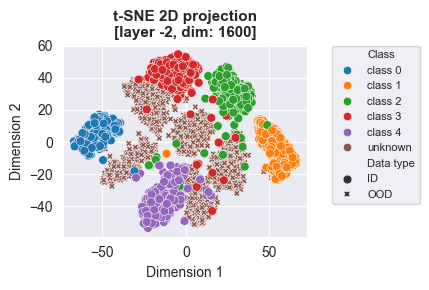

In [6]:
plt.figure(figsize=(4.5, 3))
plot_2D_features(
    model=model,
    in_dataset=ds_test_I,
    out_dataset=ds_test_O,
    output_layer_id=-2,
)
plt.tight_layout()
plt.show()

### Fit monitor

In [9]:
monitor = Mahalanobis(eps=0.002)
monitor.fit(model, feature_layers_id=[-2], fit_dataset=ds_train)

scores_I, _ = monitor.score(ds_test_I)
scores_O, _ = monitor.score(ds_test_O)

=== Metrics ===
auroc     : 0.875764
tnr95tpr  : 0.516054
=== Plots   ===


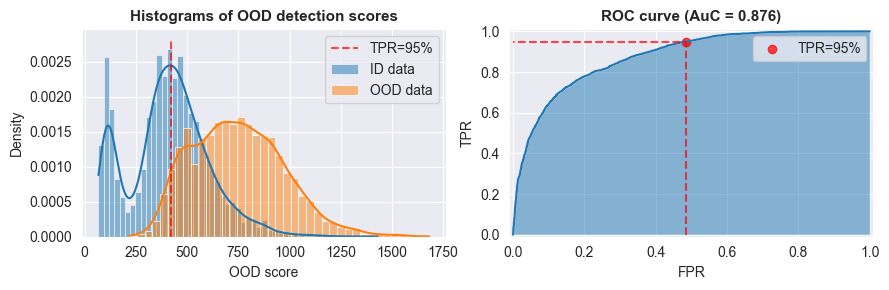

In [12]:
metrics = bench_metrics((scores_I, scores_O), metrics=["auroc", 'tnr95tpr'])

print("=== Metrics ===")
for k,v in metrics.items():
    print(f"{k:<10}: {v:.6f}")

print("=== Plots   ===")
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_I, scores_O, log_scale=False)
plt.subplot(122)
plot_roc_curve(scores_I, scores_O)
plt.tight_layout()
plt.show()